In [0]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [0]:
!pip install torch torchvision numpy matplotlib

In [0]:
import torch
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch import nn
import numpy as np

import matplotlib.image as mpimg
%matplotlib inline

In [0]:
!cd "/content/drive/My Drive/Pneumonia classification"

## Data


### Normal CXR

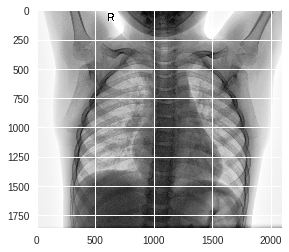

In [0]:
img = mpimg.imread("/content/drive/My Drive/Pneumonia classification/Pneumonia data/train/NORMAL/IM-0115-0001.jpeg")
img = plt.imshow(img)
plt.show()

### Pneumonia

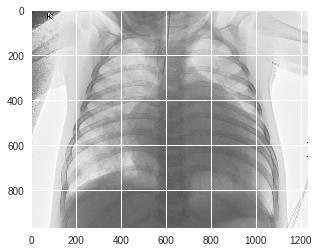

In [0]:
img = mpimg.imread("/content/drive/My Drive/Pneumonia classification/Pneumonia data/train/PNEUMONIA/person22_bacteria_74.jpeg")
img = plt.imshow(img)
plt.show()

## Loading and transforming data

In [0]:
augmented_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])


train_data = datasets.ImageFolder("/content/drive/My Drive/Pneumonia classification/Pneumonia data/train",transform=augmented_transform)
valid_data = datasets.ImageFolder("/content/drive/My Drive/Pneumonia classification/Pneumonia data/val",transform=transform)
test_data = datasets.ImageFolder("/content/drive/My Drive/Pneumonia classification/Pneumonia data/test",transform=transform)

batch_size = 50
num_workers = 0
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,num_workers=num_workers,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,batch_size=batch_size,num_workers=num_workers,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,num_workers=num_workers,shuffle=True,drop_last=True)


## ResNet34 for transfer learning

In [0]:
model = models.resnet34(pretrained=True)

for params in model.parameters():
    params.requires_grad = False
    
for params in model.fc.parameters():
    params.requires_grad = True
    
new_classifier = nn.Linear(512,2)
model.fc = new_classifier    

model.cuda()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [0]:
n_epoch = 15
valid_loss_min = np.Inf

for epoch in range(n_epoch):
    train_loss = 0
    valid_loss = 0
    
    for data, target in train_loader:
        data, target = data.cuda(),target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()/batch_size
        
    for data,target in valid_loader:
        data, target = data.cuda(),target.cuda()
        output = model(data)
        loss = criterion(output,target)
        valid_loss += loss.item()/batch_size
        
    print("Epoch:",epoch,"Training Loss:",train_loss,"Validation Loss:",valid_loss)
    if valid_loss < valid_loss_min:
        print("Validation loss decreasing. Saving model...")
        valid_loss_min = valid_loss
        torch.save(model.state_dict(),"pneumonia_param.pt")

Epoch: 0 Training Loss: 0.7288592469692229 Validation Loss: 0.018335702419281005
Validation loss decreasing. Saving model...
Epoch: 1 Training Loss: 0.5955801945924759 Validation Loss: 0.019524614810943603
Epoch: 2 Training Loss: 0.5740718221664429 Validation Loss: 0.03129163503646851
Epoch: 3 Training Loss: 0.5663213348388673 Validation Loss: 0.017936379909515382
Validation loss decreasing. Saving model...
Epoch: 4 Training Loss: 0.5407197138667106 Validation Loss: 0.014319024085998534
Validation loss decreasing. Saving model...
Epoch: 5 Training Loss: 0.5503696568310261 Validation Loss: 0.018140701055526735
Epoch: 6 Training Loss: 0.5335959124565125 Validation Loss: 0.01888904333114624
Epoch: 7 Training Loss: 0.5319035549461841 Validation Loss: 0.01960862398147583
Epoch: 8 Training Loss: 0.5395882953703403 Validation Loss: 0.02367192268371582
Epoch: 9 Training Loss: 0.5074087318778038 Validation Loss: 0.029778203964233398
Epoch: 10 Training Loss: 0.5242548260092734 Validation Loss: 0

In [0]:
model.load_state_dict(torch.load("pneumonia_param.pt"))

In [0]:
correct = 0
total = 0
test_loss = 0

for data, target in test_loader:
    data, target = data.cuda(),target.cuda()
    output = model(data)
    loss = criterion(output,target)
    test_loss += loss.item()
    _,pred = torch.max(output.data,1) #note: output.data is used because output contains other info as well, such as optimizer and grad
    for i in range(batch_size):
        if pred[i].item()==target[i].item():
          correct+=1
        total+=1

print("Test loss:",test_loss)
print("Test accuracy:",correct/total*100,"%","(",correct,"/",total,")")

Test loss: 4.651096850633621
Test accuracy: 84.83333333333334 % ( 509 / 600 )
